In [12]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from statsmodels.tsa.arima.model import ARIMA
import os
import string
import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import statsmodels.api as sm
import warnings
import seaborn as sns


from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
#electricity consumption data
electr_residential = pd.read_csv('../../../data/tidy/residential-electricity-2016to2022.csv') 
electr_commer_indust = pd.read_csv('../../../data/tidy/commercial-electricity-2016to2022.csv')

electr_commer_indust = electr_commer_indust.iloc[::-1]

# If you want to reset the index after flipping, you can do:
electr_commer_indust.reset_index(drop=True, inplace=True)
electr_commer_indust.set_index('Unnamed: 0', inplace=True)
electr_commer_indust.index.name = 'index'
electr_commer_indust.drop(electr_commer_indust.columns[0], axis=1, inplace=True)


electr_residential = electr_residential.iloc[::-1]

# If you want to reset the index after flipping, you can do:
electr_residential.reset_index(drop=True, inplace=True)
electr_residential.set_index('Unnamed: 0', inplace=True)
electr_residential.index.name = 'index'
electr_residential.drop(electr_residential.columns[0], axis=1, inplace=True)

electric_results = electr_commer_indust+electr_residential

#assuming constant emissions factor
Total_EF = 543.852

electric_results = electric_results/1000*Total_EF/2204.62/1000000 #unit (MMTCO2e)

# Define new column names
new_column_names = ['New Haven (MMTCO2e)', 'Hartford (MMTCO2e)', 'Bridgeport (MMTCO2e)']

# Assign new column names to the DataFrame
electric_results.columns = new_column_names

electric_results.index.name = 'year'


electric_results.index = pd.to_datetime(electric_results.index, format='%Y')
electric_results.index.freq = 'AS'
df=electric_results
df.to_csv('../../../data/tidy/electricity-emissions-msa-paper.csv')
df

,New Haven (MMTCO2e),Hartford (MMTCO2e),Bridgeport (MMTCO2e)
year,,,
2016-01-01,1.430073,1.924097,1.792147
2017-01-01,1.355028,2.231089,1.706469
2018-01-01,1.449108,2.108849,1.726713
2019-01-01,1.374215,1.844642,1.674141
2020-01-01,1.303380,1.756536,1.590311
2021-01-01,1.314940,1.790219,1.671623
2022-01-01,1.353627,1.842788,1.688185


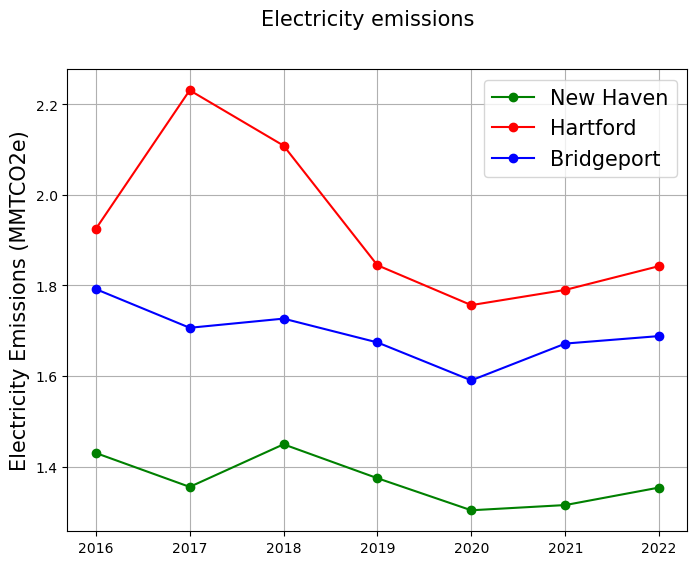

In [3]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Electricity emissions',fontsize=15)
actual, = plt.plot(df.index, df['New Haven (MMTCO2e)'], 'go-', label='New Haven')
actual, = plt.plot(df.index, df['Hartford (MMTCO2e)'], 'ro-', label='Hartford')
actual, = plt.plot(df.index, df['Bridgeport (MMTCO2e)'], 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('Electricity Emissions (MMTCO2e)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
plt.grid()
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.savefig('../../../figures/electricity-emissions-historical-change.png', dpi=600, bbox_inches='tight')

In [4]:
#split the test and trainig set
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()


df_train.index.freq = 'AS'
df_test.index.freq = 'AS'

In [5]:
len(df_test)

1

In [6]:
len(df_train)

6

In [7]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['New Haven (MMTCO2e)'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -1.975987
p-value: 0.297200


In [8]:
HEM_data = df['Hartford (MMTCO2e)']
NHM_data = df['New Haven (MMTCO2e)']
BSN_data = df['Bridgeport (MMTCO2e)']

In [9]:
import warnings
warnings.filterwarnings("ignore")

def performance_metric(test, forecast):#observed and predicted
    """
    Evaluate forecast using different metrics.
    """
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mape, mae, rmse

def arima_prediction(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Generate predictions for the test set
    pred = res.get_prediction(start=len(train), end=len(train) + len(test) - 1)
    pred_mean = pred.predicted_mean
    
    # Evaluate forecast
    mape, mae, rmse = performance_metric(test, pred_mean)
    
    # Calculate BIC and AIC
    bic = res.bic
    #aic = res.aic
    
    return mape, mae, rmse, bic

def gridsearch(data): 

    # Initialize list to store results
    results_list_cv = []

    p_values = range(0,8)
    d_values = range(1,2)
    q_values = range(0,8)

    # Loop through each combination of p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mape_cv = []
                mae_cv = []
                rmse_cv = []
                bic_cv = []
            

                split_index = round(len(data)*0.8)
                train = data.iloc[:split_index].copy()
                test = data.iloc[split_index:].copy()

                mape, mae, rmse, bic = arima_prediction(train, test, order)
                mape_cv.append(mape)
                mae_cv.append(mae)
                rmse_cv.append(rmse)
                bic_cv.append(bic)
                    #aic_cv.append(aic)
                    


                # Calculate the mean of metrics across folds
                mape_mean = np.mean(mape_cv)
                mae_mean = np.mean(mae_cv)
                rmse_mean = np.mean(rmse_cv)
                bic_mean = np.mean(bic_cv)
                #aic_mean = np.mean(aic_cv)

                # Store results
                results_list_cv.append({'p': p, 'd': d, 'q': q, 'MAPE': mape_mean, 'MAE': mae_mean, 'RMSE': rmse_mean, 'BIC':bic_mean})

    # Convert list of dictionaries to DataFrame
    results_df = pd.DataFrame(results_list_cv)
    return results_df

            
# Convert list of dictionaries to DataFrame
results_df_HEM_cv=gridsearch(HEM_data)
results_df_NHM_cv=gridsearch(NHM_data)
results_df_BSN_cv=gridsearch(BSN_data)

print(results_df_HEM_cv)

    p  d  q      MAPE       MAE      RMSE        BIC
0   0  1  0  2.852705  0.052569  0.052569  -2.280355
1   0  1  1  2.930028  0.053994  0.053994  -2.271957
2   0  1  2  2.852660  0.052568  0.052568 -38.791355
3   0  1  3  2.855175  0.052615  0.052615 -15.311543
4   0  1  4  2.852705  0.052569  0.052569       -inf
.. .. .. ..       ...       ...       ...        ...
59  7  1  3  2.852705  0.052569  0.052569        NaN
60  7  1  4  2.852705  0.052569  0.052569        NaN
61  7  1  5  2.852705  0.052569  0.052569        NaN
62  7  1  6  2.852705  0.052569  0.052569        NaN
63  7  1  7  2.852705  0.052569  0.052569        NaN

[64 rows x 7 columns]


In [10]:
test_HEM =results_df_HEM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
HEM=test_HEM.sort_values(by='RMSE').iloc[:65,:]

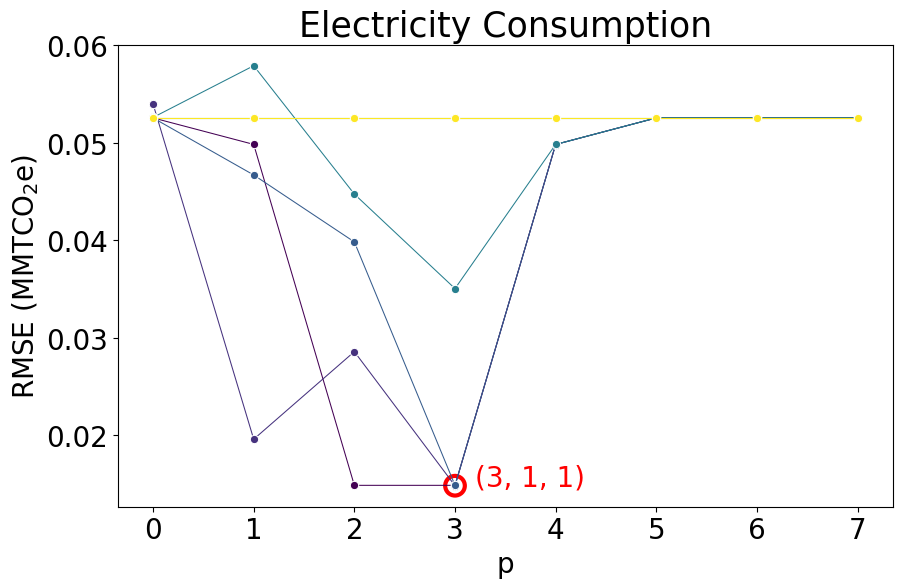

In [18]:
# Plotting
plt.figure(figsize=(10, 6))

# Using seaborn lineplot to plot data with different sizes and colors for d and q
sns.lineplot(
    data=HEM,
    x='p',
    y='RMSE',
    size='d',
    hue='q',# Annotating the point (1, 2, 0) with a red hollow circle
    palette='viridis',
    markers=True,
    style='d',
    legend=False
    #markersize=10
)

# Adding labels and title
plt.title('Electricity Consumption', fontsize=25)
plt.xlabel('p', fontsize=20)
plt.ylabel('RMSE (MMTCO$_2$e)', fontsize=20)

# Set x-ticks to display years from the start year
plt.xticks(range(8), fontsize=20)

# Set y-ticks to be integers and apply fontsize
plt.yticks(fontsize=20)

# Annotating the point (1, 2, 0) with a red hollow circle
highlight = HEM.loc[3, 1, 1]
p, d, q = 3, 1, 1  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')

plt.savefig('../../../figures/rmse-plot/electricity_emissions_HEM.jpg', dpi=600, bbox_inches='tight')

In [19]:
test_NHM =results_df_NHM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
NHM=test_NHM.sort_values(by='RMSE').iloc[:65,:]

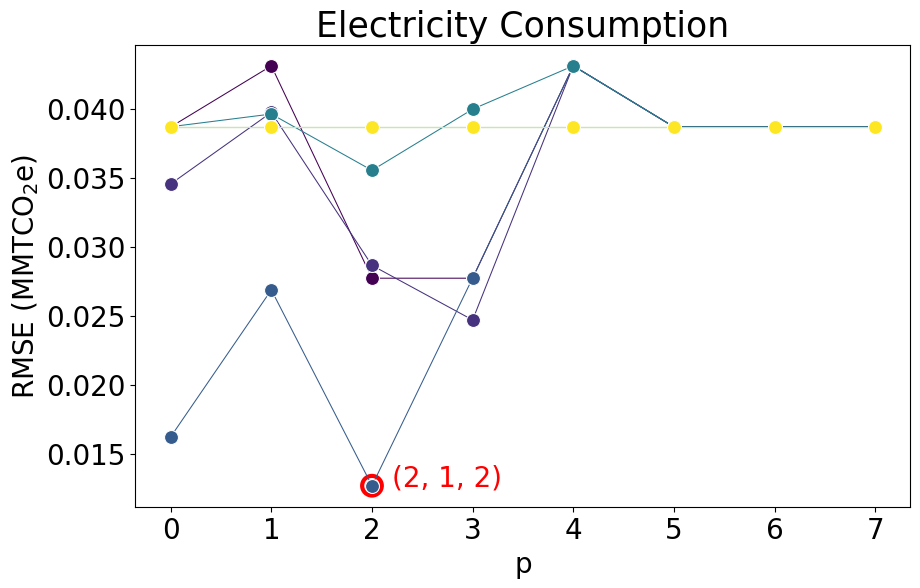

In [20]:
# Plotting
plt.figure(figsize=(10, 6))

# Using seaborn lineplot to plot data with different sizes and colors for d and q
sns.lineplot(
    data=NHM,
    x='p',
    y='RMSE',
    size='d',
    hue='q',# Annotating the point (1, 2, 0) with a red hollow circle
    palette='viridis',
    markers=True,
    style='d',
    legend=False,
    markersize=10
)

# Adding labels and title
plt.title('Electricity Consumption', fontsize=25)
plt.xlabel('p', fontsize=20)
plt.ylabel('RMSE (MMTCO$_2$e)', fontsize=20)

# Set x-ticks to display years from the start year
plt.xticks(range(8), fontsize=20)

# Set y-ticks to be integers and apply fontsize
plt.yticks(fontsize=20)

# Annotating the point (1, 2, 0) with a red hollow circle
highlight = NHM.loc[2, 1, 2]
p, d, q = 2, 1, 2  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')

plt.savefig('../../../figures/rmse-plot/electricity_emissions_NHM.jpg', dpi=600, bbox_inches='tight')

In [21]:
test_BSN =results_df_BSN_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
BSN=test_BSN.sort_values(by='RMSE').iloc[:65,:]
BSN

MAPE       MAE      RMSE        BIC
p d q                                          
0 1 0   0.981069  0.016562  0.016562  -9.149879
4 1 4   0.981069  0.016562  0.016562       -inf
    5   0.981069  0.016562  0.016562        NaN
    6   0.981069  0.016562  0.016562        NaN
    7   0.981069  0.016562  0.016562        NaN
...          ...       ...       ...        ...
    2   2.411116  0.040704  0.040704 -20.523487
1 1 1   2.494008  0.042103  0.042103  -4.050671
    3   3.071809  0.051858  0.051858 -16.975285
0 1 3   4.245057  0.071664  0.071664  -5.765533
2 1 2  13.127880  0.221623  0.221623 -11.321018

[64 rows x 4 columns]

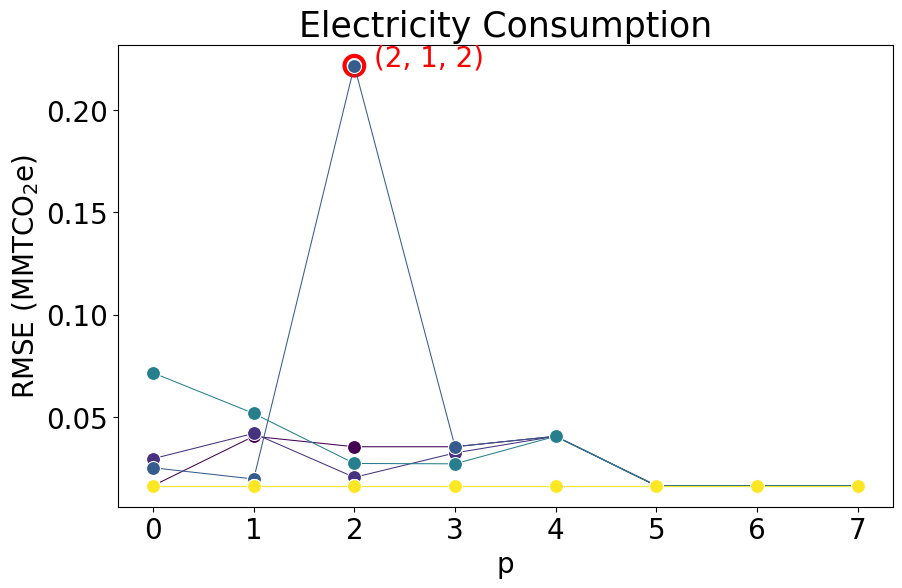

In [22]:
# Plotting
plt.figure(figsize=(10, 6))

# Using seaborn lineplot to plot data with different sizes and colors for d and q
sns.lineplot(
    data=BSN,
    x='p',
    y='RMSE',
    size='d',
    hue='q',# Annotating the point (1, 2, 0) with a red hollow circle
    palette='viridis',
    markers=True,
    style='d',
    legend=False,
    markersize=10
)

# Adding labels and title
plt.title('Electricity Consumption', fontsize=25)
plt.xlabel('p', fontsize=20)
plt.ylabel('RMSE (MMTCO$_2$e)', fontsize=20)

# Set x-ticks to display years from the start year
plt.xticks(range(8), fontsize=20)

# Set y-ticks to be integers and apply fontsize
plt.yticks(fontsize=20)

# Annotating the point (1, 2, 0) with a red hollow circle
highlight = BSN.loc[2, 1, 2]
p, d, q = 2, 1, 2  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')

plt.savefig('../../../figures/rmse-plot/electricity_emissions_BSN.jpg', dpi=600, bbox_inches='tight')

In [ ]:
def arima_forecast(train, test, order,forecast_horizon,plot_file,color1,color2):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    forecast = res.forecast(steps=forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    forecast.index = range(2023, 2023 + forecast_horizon)
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel('Emissions (MTCO2e)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3 # Change this value to set the desired interval

# Set x-ticks with the specified interval
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))

    # Save the plot
    plt.savefig(plot_file)

    return res,forecast,confidence_interval

HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
HEM_data = df['Hartford (MMTCO2e)']
plot_file = '../../../figures/hartford-forecast-emissions-electricity.png'  # File to save the plot

HEM_summary,HEM_forecast,HEM_confidence_interval=arima_forecast(HEM_data, HEM_test,(3,1,1),13, plot_file,'salmon','orange')#chagne the function name. make function shorter; call old function in new function
HEM_summary.summary()

In [ ]:
import matplotlib.pyplot as plt

def arima_forecast_1(train, order, forecast_horizon, plot_file, color1, color2):
    # Fit the ARIMA model with the specified order
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Forecasting
    forecast = res.forecast(steps=forecast_horizon)
    forecast.index = range(2023, 2023 + forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    # Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')
    plt.ylabel('VMT (billion miles)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))
    
    # Save the forecast plot
    plt.savefig(plot_file)
    plt.close()
    
    # Impulse Response Calculation
    impulse_responses = res.impulse_responses(steps=forecast_horizon, impulse=0, orthogonalized=False, cumulative=False, anchor='end')
    
    # Ensure the length of impulse_responses matches the forecast_horizon
    impulse_responses = impulse_responses[:forecast_horizon]
    
    return res, forecast, confidence_interval, impulse_responses

def plot_multiple_irfs(irf_data, forecast_horizon, start_year, plot_file):
    plt.figure(figsize=(10, 6))
    
    for region, irf in irf_data.items():
        plt.plot(
            range(0, forecast_horizon),
            irf['impulse_responses'],
            marker=irf.get('marker', 'o'),  # default marker if 'marker' key is missing
            label=f'{region}',
            color=irf.get('color', None),  # default color if 'color' key is missing
            linestyle=irf.get('linestyle', '-'),  # default linestyle if 'linestyle' key is missing
            linewidth=irf.get('linewidth', 2),  # default linewidth if 'linewidth' key is missing
            alpha=irf.get('alpha', 0.7),  # default alpha if 'alpha' key is missing
            markersize=irf.get('markersize', 6)  # default markersize if 'markersize' key is missing
        )
    
    #plt.xlabel('Year', fontsize=20)
    plt.ylabel('Impulse response (MMTCO$_2$e)', fontsize=20)
    plt.xlabel('Forecast year', fontsize=20)
    #plt.legend(fontsize=12)
    plt.title('Electricity Consumption', fontsize=25)
    plt.grid(True)
    
    # Set x-ticks to display years from the start year
    plt.xticks(range(0, forecast_horizon, 2))
    plt.xticks(fontsize=20)
    
    plt.xticks(fontsize=20) 
    # Set y-ticks to be integers
    max_y = 8  # Replace with your actual maximum value if different
    plt.yticks(range(-4, max_y + 1))
    
    plt.ylim(-4, 8)
    plt.yticks(fontsize=20)
    
    # Adjust the spacing and save the plot
    plt.margins(x=0, y=0)
    plt.savefig(plot_file, dpi=600, bbox_inches='tight')

    
    
    # Title, labels, ticks, and other plot formatting as per your code

# Set the x-axis ticks




# Assuming df is your DataFrame and it contains columns for each region
regions = {
    'Hartford': {
        'data': df['Hartford (MMTCO2e)'],
        'order': (3, 1, 1),
        'color': 'tomato',
        'marker': 'o',
        'linestyle': '--',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12
    },
    'New Haven': {
        'data': df['New Haven (MMTCO2e)'],
        'order': (2, 1, 2),
        'color': 'orange',
        'marker': 's',
        'linestyle': '-.',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12
    },
    'Bridgeport': {
        'data': df['Bridgeport (MMTCO2e)'],
        'order': (2, 1, 2),
         'color': 'green', 
        'marker': 'x',
        'linestyle': ':',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12
    }
}


forecast_horizon = 13
start_year = 2023
irf_data = {}

for region, params in regions.items():
    plot_file = f'../../../figures/{region.lower().replace(" ", "")}-forecast-vmt.png'
    summary, forecast, confidence_interval, impulse_responses = arima_forecast_1(params['data'], params['order'], forecast_horizon, plot_file, params['color'], params['color'])
    irf_data[region] = {
        'impulse_responses': impulse_responses,
        'color': params['color'],
        'marker': params['marker'],  # Adding marker information
        'linestyle': params['linestyle'],  # Adding linestyle information
        'linewidth': params['linewidth'],  # Adding linewidth information
        'alpha': params['alpha'],  # Adding alpha information
        'markersize': params['markersize']
    }

# Plot all impulse response functions together
irf_plot_file = '../../../figures/impulse-function/electricity-IRF.jpg'
plot_multiple_irfs(irf_data, forecast_horizon, start_year, irf_plot_file)


In [ ]:
def arima_test_data_performance_metrics(train, test,order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    test_forecast_mean = test_forecast.predicted_mean

    new_index = range(2023-len(test),2023)
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Emissions (MMTCO2e)'])
    test_forecast_df['Year'] = new_index


    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)
    
    test_forecast_df.index = pd.to_datetime(test_forecast_df.index, format='%Y')


    actual_values = test
    predicted_values = test_forecast_df['Emissions (MMTCO2e)']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    bic = res.bic

    return mae, rmse, mape,bic

HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
mae, rmse, mape,bic= arima_test_data_performance_metrics(HEM_train, HEM_test,(3,1,1))
print(mae)
print(rmse)
print(mape)

In [ ]:
BSN_train = df_train['Bridgeport (MMTCO2e)']
BSN_test = df_test['Bridgeport (MMTCO2e)']
BSN_data = df['Bridgeport (MMTCO2e)']
plot_file = '../../../figures/bridgeport-forecast-emissions-electricity.png'  # File to save the plot

BSN_summary,BSN_forecast,BSN_confidence_interval=arima_forecast(BSN_data, BSN_test,(2,1,2),13, plot_file,'blue','lightblue')#chagne the function name. make function shorter; call old function in new function
BSN_summary.summary()

In [ ]:
BSN_summary.pvalues

In [ ]:
mae, rmse, mape,bic = arima_test_data_performance_metrics(BSN_train, BSN_test,(2,1,2))
print(mae,rmse, mape,bic)

In [ ]:
# NHM_train = df_train['New Haven (MMTCO2e)']
NHM_test = df_test['New Haven (MMTCO2e)']
NHM_data = df['New Haven (MMTCO2e)']
plot_file = '../../../figures/newhaven-forecast-emissions-electricity.png'  # File to save the plot

NHM_summary,NHM_forecast,NHM_confidence_interval=arima_forecast(NHM_data, NHM_test, (2,1,2),13, plot_file,'green','lightgreen')#chagne the function name. make function shorter; call old function in new function
NHM_summary.summary()

In [ ]:
NHM_summary.pvalues

In [ ]:
NHM_train = df_train['New Haven (MMTCO2e)']
NHM_test = df_test['New Haven (MMTCO2e)']
mae, rmse, mape,bic = arima_test_data_performance_metrics(NHM_train, NHM_test,(2,1,2))
print(mae, rmse, mape,bic)

In [ ]:
def test_train_fitting_VMT(train,order):
    # Forecast on training data
    mod = sm.tsa.arima.ARIMA(train, order=order)
    res = mod.fit()
    
    train_forecast = res.get_prediction(start=0, end=len(train)-1)
    train_forecast_mean = train_forecast.predicted_mean
    train_conf_int = train_forecast.conf_int()

    #test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    #test_forecast_mean = test_forecast.predicted_mean
    #test_conf_int = test_forecast.conf_int()
    
    return train_forecast_mean,train_conf_int
    

emissions_train_HEM,train_conf_int_HEM=test_train_fitting_VMT(HEM_data,(3,1,1))
emissions_train_NHM,train_conf_int_NHM=test_train_fitting_VMT(NHM_data,(2,1,2))
emissions_train_BSN,train_conf_int_BSN=test_train_fitting_VMT(BSN_data,(2,1,2))

In [ ]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
concatenated_predicted_forecast_HEM = pd.concat([emissions_train_HEM,HEM_forecast])[1:]

plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_forecast_HEM.index, concatenated_predicted_forecast_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

concatenated_confidence_interval_HEM = pd.concat([train_conf_int_HEM, HEM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_HEM[1:].index, concatenated_confidence_interval_HEM.iloc[1:, 0], concatenated_confidence_interval_HEM.iloc[1:, 1], color='lightcoral', alpha=0.3)



concatenated_observed_NHM = pd.concat([NHM_train,NHM_test])[1:]
NHM_forecast.index = pd.to_datetime(NHM_forecast.index, format='%Y')
concatenated_predicted_forecast_NHM = pd.concat([emissions_train_NHM,NHM_forecast])[1:]

plt.plot(concatenated_observed_NHM.index, concatenated_observed_NHM,label='New Haven_Observed', color='orange')
plt.plot(concatenated_predicted_forecast_NHM.index, concatenated_predicted_forecast_NHM, label='New Haven_Fitted', color='orange', linestyle='--')

concatenated_confidence_interval_NHM = pd.concat([train_conf_int_NHM, NHM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_NHM[1:].index, concatenated_confidence_interval_NHM.iloc[1:, 0], concatenated_confidence_interval_NHM.iloc[1:, 1], color='orange', alpha=0.3)


concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
concatenated_predicted_forecast_BSN = pd.concat([emissions_train_BSN,BSN_forecast])[1:]

plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_forecast_BSN.index, concatenated_predicted_forecast_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

concatenated_confidence_interval_BSN = pd.concat([train_conf_int_BSN, BSN_confidence_interval])
plt.fill_between(concatenated_confidence_interval_BSN[1:].index, concatenated_confidence_interval_BSN.iloc[1:, 0], concatenated_confidence_interval_BSN.iloc[1:, 1], color='olivedrab', alpha=0.3)


# Legend for Colors (Locations)
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
deepskyblue_patch = mpatches.Patch(color='orange', label='New Haven Area')
green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch, green_patch], title="", fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))

# Add the first legend manually to the plot
plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
#plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Electricity Consumption', fontsize=25)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)

plt.xticks(fontsize=20, rotation=45) 
plt.yticks(fontsize=20)
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set starting and ending dates for x-axis ticks
plt.xlim(datetime.datetime(2017, 1, 1), datetime.datetime(2035, 1, 1))


# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2022, 1, 1), color='black', linestyle='--', label='Year 2022 (X-axis)')


plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5)

max_y_value = 3
plt.yticks(np.arange(0, max_y_value, 0.5))






plt.savefig('../../../figures/electricity_forecast.png', dpi=600, bbox_inches='tight')

In [ ]:
concatenated_observed_BSN

In [ ]:
HEM_2022 = concatenated_observed_HEM[-1]
HEM_2035 = concatenated_predicted_forecast_HEM[-1]
HEM_per = (HEM_2022-HEM_2035)/HEM_2022*100 #%

In [ ]:
NHM_2022 = concatenated_observed_NHM[-1]
NHM_2035 = concatenated_predicted_forecast_NHM[-1]
NHM_per = (NHM_2022-NHM_2035)/NHM_2022*100 #%

In [ ]:
BSN_2022 = concatenated_observed_BSN[-1]
BSN_2035 = concatenated_predicted_forecast_BSN[-1]
BSN_per = (BSN_2022-BSN_2035)/BSN_2022*100 #%

In [ ]:
print(HEM_per,NHM_per,BSN_per)

In [ ]:
concatenated_predicted_forecast_HEM.index = pd.to_datetime(concatenated_predicted_forecast_HEM.index)
concatenated_observed_HEM.index = pd.to_datetime(concatenated_observed_HEM.index)

# Extract data for the year 2021
HEM_2021 = concatenated_observed_HEM['2021'].values
HEM_2035 = concatenated_predicted_forecast_HEM['2035'].values


concatenated_predicted_forecast_NHM.index = pd.to_datetime(concatenated_predicted_forecast_NHM.index)
concatenated_observed_NHM.index = pd.to_datetime(concatenated_observed_NHM.index)

NHM_2021 = concatenated_observed_NHM['2021'].values
NHM_2035= concatenated_predicted_forecast_NHM['2035'].values


concatenated_predicted_forecast_BSN.index = pd.to_datetime(concatenated_predicted_forecast_BSN.index)
concatenated_observed_BSN.index = pd.to_datetime(concatenated_observed_BSN.index)

# Extract data for the year 2021
BSN_2021 = concatenated_observed_BSN['2021'].values
BSN_2035= concatenated_predicted_forecast_BSN['2035'].values


#how to calculate the difference: the difference equals the (old-new)/old
NHM_per = (NHM_2021-NHM_2035)/NHM_2021*100 #%

HEM_per = (HEM_2021-HEM_2035)/HEM_2021*100 #%

BSN_per = (BSN_2021-BSN_2035)/BSN_2021*100 #%

print(HEM_per,NHM_per,BSN_per)

In [ ]:
df = pd.DataFrame({'Column1': -HEM_per, 'Column2': -NHM_per, 'Column3': -BSN_per})
df

In [ ]:
data = pd.DataFrame({'Column1': HEM_2021, 'Column2': HEM_2035, 'Column3': NHM_2021, 'Column4': NHM_2035, 'Column5': BSN_2021, 'Column6': BSN_2035})
data

In [ ]:
concatenated_confidence_interval_HEM['ME'] = (concatenated_confidence_interval_HEM.iloc[:, 1] - concatenated_confidence_interval_HEM.iloc[:, 0]) / 2
concatenated_confidence_interval_HEM

In [ ]:
concatenated_confidence_interval_NHM['ME'] = (concatenated_confidence_interval_NHM.iloc[:, 1] - concatenated_confidence_interval_NHM.iloc[:, 0]) / 2
concatenated_confidence_interval_NHM

In [ ]:
concatenated_confidence_interval_BSN['ME'] = (concatenated_confidence_interval_BSN.iloc[:, 1] - concatenated_confidence_interval_BSN.iloc[:, 0]) / 2
concatenated_confidence_interval_BSN